# n-widths for transport problems 
## Heaviside step function
$u(x;\mu) = f(x, \mu) = \begin{cases}
    0.0 & \text{if $x < \mu $} \\
    0.5 & \text{if $x = \mu $} \\
    1.0 & \text{if $x > \mu $}
  \end{cases}$ 
  
  $ x \in ({0,1})$ and $ \mu \in ({0,1})$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd, orth, qr
from scipy.optimize import curve_fit
from numpy import sin, cos, pi
cmap = plt.cm.plasma

In [2]:
from initial_conditions import Domain, Heaviside, LinearRamp, SmoothRamp, Sigmoid, CkRamp, Polynoms
from basis_functions import SVD, Trigonometric, Trigonometric2, TrigonometricOdd, Greedy, LNA, LPF, Sinc

We need to set some boring plotting options...:

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
page_width_pt = 455.24
pt2in = 0.01389 
pt2cm = 0.0352777778
cm2in = 1/2.54
plot_width_in = page_width_pt*pt2in/2
print(plot_width_in/cm2in)

plt.rcParams["figure.figsize"] = (plot_width_in, plot_width_in/1.61803398875)
plt.rcParams['font.size'] = 12
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
#mpl.rc('text', usetex=True)
mpl.rc('font', family='serif', size=12, serif='Computer Modern Roman')

8.030570172000001


In [4]:
def plot_modes(x, X, r=10):
    for i in range(r):
        print(i, r, i/r)
        plt.plot(x, X[:, i], "o", ms=1, color=cmap(i/(r-1)), label="mode {:.0f}".format(i))
    plt.xlim([0, 1])
    plt.grid(which="both")
    return

def plot_and_compare_modes(x, U1, U2, r=6):
    fig, ax1 = plt.subplots()
    for i in range(r):
        plt.plot(x, U1[:, i], "o", ms=1, color=cmap(i/(r-1)), label="mode {:.0f}".format(i))
    for i in range(r):  # fix z-order
        plt.plot(x, U2[:, i], "k--")
    plt.xlim([0, 1])
    plt.grid(which="both")
    plt.show()
    return

def plot_singular_values(S):
    S = S/S[0].copy()  # normalize singular values to make for a better comparison!
    fig, ax1 = plt.subplots()
    ax1.plot(np.arange(1, len(S)+1), S, "k.", ms=1)
    ax1.set_xlabel("order")
    ax1.set_ylabel("singular value")
    ax1.set_yscale('log')
    ax1.set_xlim([0, len(S)])
#    ax1.set_ylim([1e-6, 100])
    ax1.grid(which="both")
    plt.tight_layout()
    plt.show()
    return fig, ax1

def plot_error(rms_error, max_error):
    fig, ax = plt.subplots()
    ax.plot(max_error, ".", label="max_error")
    ax.plot(rms_error, ".", label="rms_error")
    ax.set_yscale('log')
    plt.legend(prop={'size': 8})
    return fig, ax

def plot_paramspace(X):
    fig, ax = plt.subplots()
    plt.imshow(X, interpolation="none")
    ax.set_xlabel("$\mu$")
    ax.set_ylabel("$x$")
    plt.show()
    return fig, ax

def save_im(res, name):
    print(res.min(), res.max())
    fig, ax = plt.subplots()
    cs = plt.imshow(res, interpolation="nearest", origin="upper")
    plt.colorbar(cs)
    a = np.round(cmap(res/2+0.5)*256, decimals=0)
    img = np.array(a-1, dtype=np.uint8)
    from PIL import Image
    im = Image.fromarray(img)
    im.save(name+'.png')
    plt.close()

In [5]:
def sort_trig_basis(trig_basis_odd, X):
    V_k = trig_basis_odd.U.reshape(m, -1, 2)  # x, r, 2
    V_1 = V_k[:, :, 0].copy()  # sin
    c = V_1.T @ X  # V_1.T @ X is slow!
    c_n = (c**2).sum(axis=1)
    order = np.argsort(-c_n)
    trig_basis_odd.U = V_k[:, order, :].reshape(m, -1)
    trig_basis_odd.frequencies = trig_basis_odd.frequencies[order]
    return None


def SVD_vs_trig_basis(svd_basis, trig_basis_odd):
    # correlation matrix
    cm = trig_basis_odd.U.T @ svd_basis.U  # (n, m) (m, r) = n, r
    frequencies = trig_basis_odd.frequencies
    x = trig_basis_odd.x
    A = trig_basis_odd.A
    m, r = trig_basis_odd.U.shape
    e = np.zeros(r,)

    for i in range(m//2):  # m//2
        SVD_psi_1 = svd_basis.U[:, 2*i]
        SVD_psi_2 = svd_basis.U[:, 2*i+1]
        f1 = f2 = frequencies[i]
        # c1 and c2 are equal, unless th sign of the SVD is flipped.
        # A flipped sign looks like a phase shift by +- pi
        # we dont know when that happens, we just compute a new c 
        cos_c1 = cm[2*i, 2*i]  # n, r
        sin_c1 = -cm[2*i+1, 2*i]
        sin_c2 = cm[2*i, 2*i+1]
        cos_c2 = cm[2*i+1, 2*i+1]

        c1 = np.arctan2(sin_c1, cos_c1)
        psi_1 = A*np.sin(2*np.pi*f1*x-c1)

        c2 = np.arctan2(sin_c2, cos_c2)
        psi_2 = A*np.cos(2*np.pi*f2*x-c2)

        e[2*i] = ((SVD_psi_1-psi_1)**2).sum()**.5
        e[2*i+1] = ((SVD_psi_2-psi_2)**2).sum()**.5
    return e

In [6]:
m, n, r = 2500, 2500, 500
x = Domain([0, 1], m)
mu = Domain([0, 1], n)

heaviside


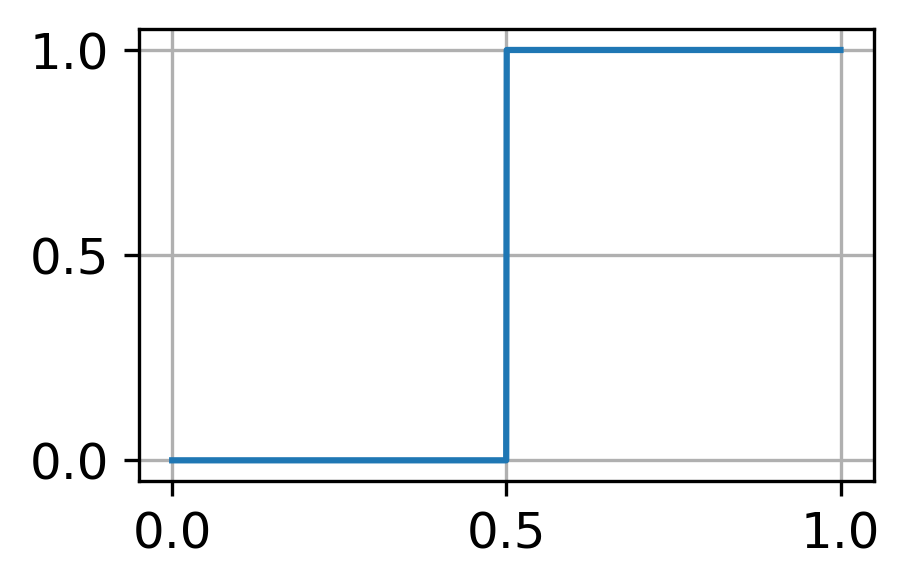

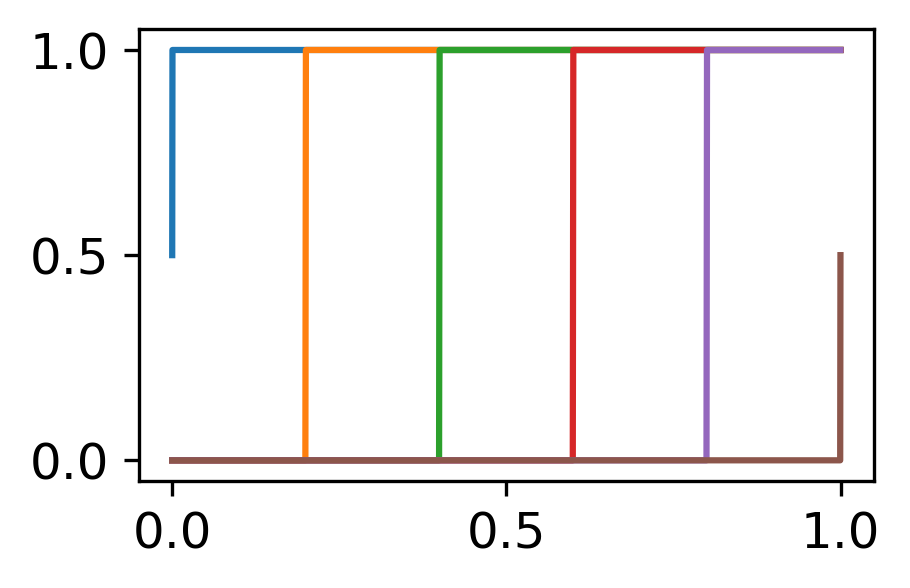

SVD'ed.


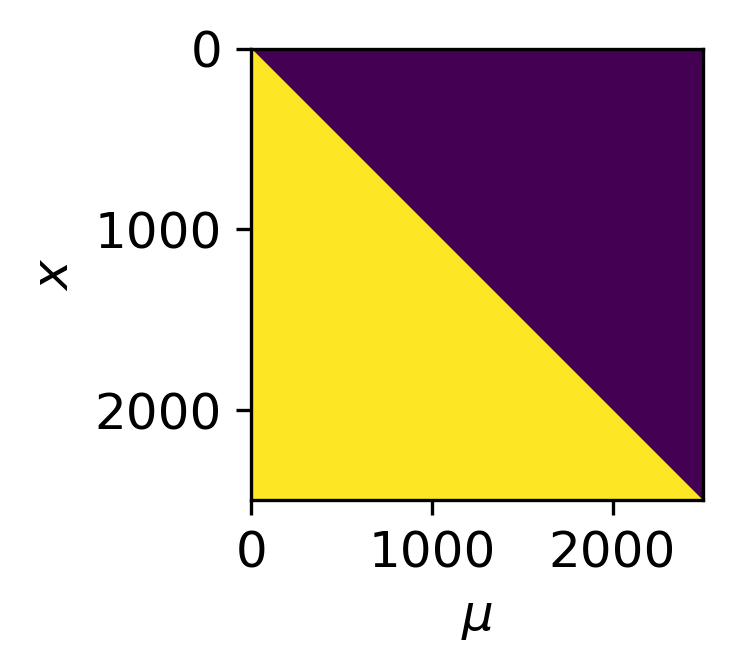

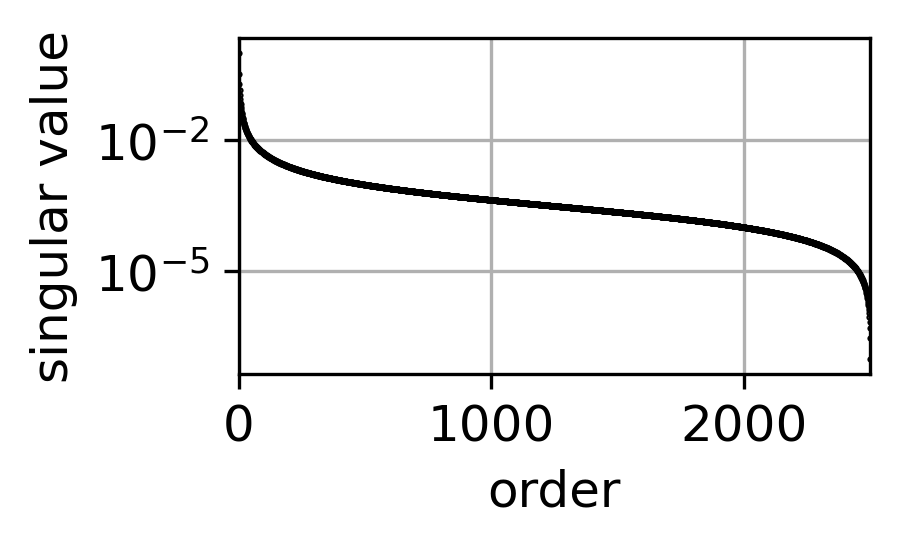

svd
linear ramp, C^0


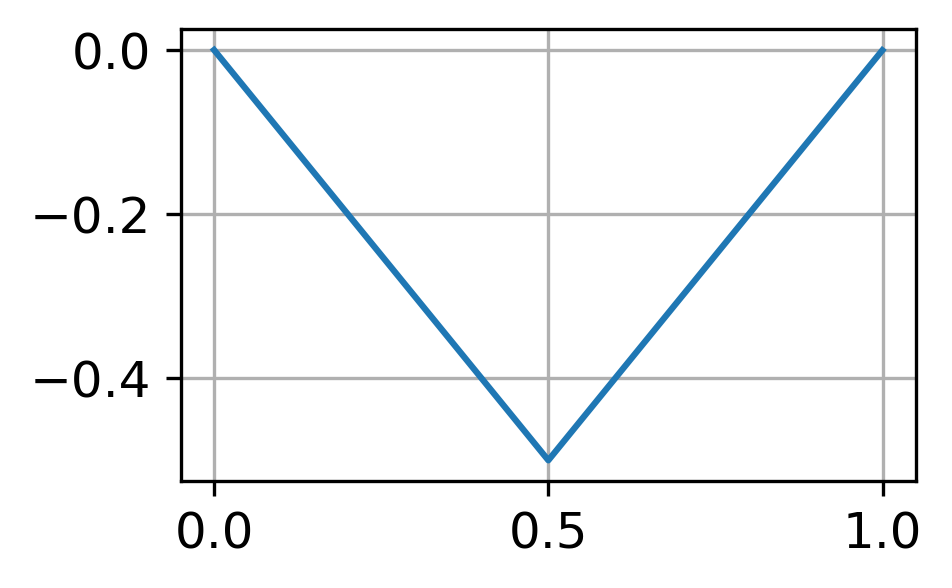

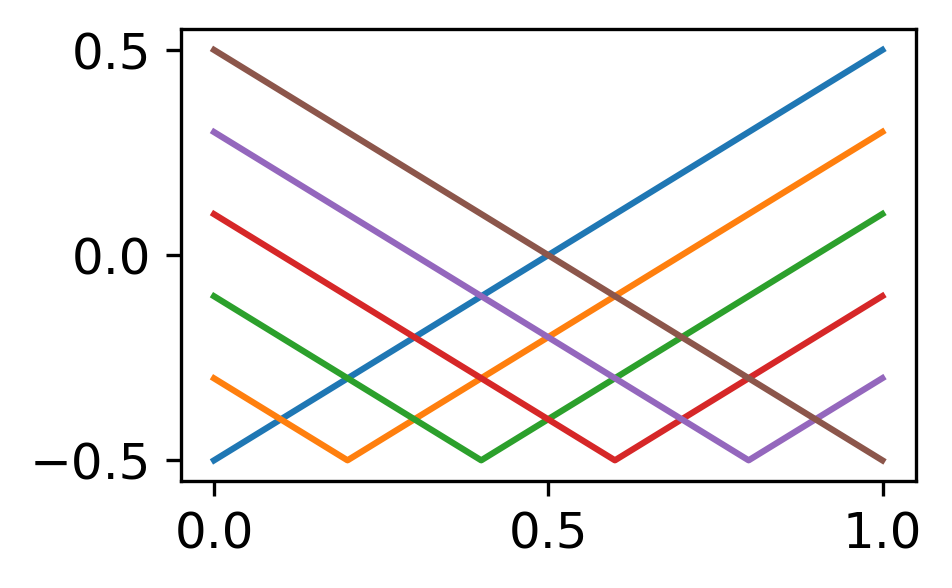

SVD'ed.


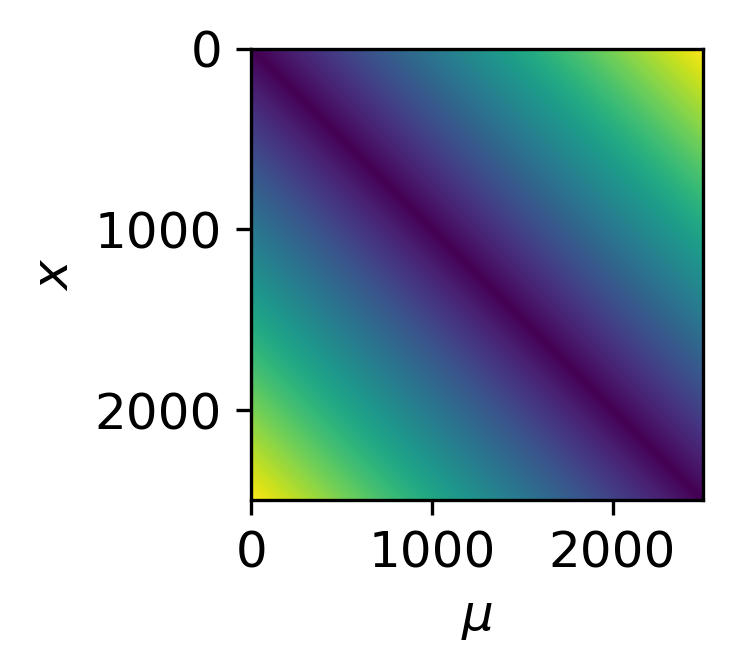

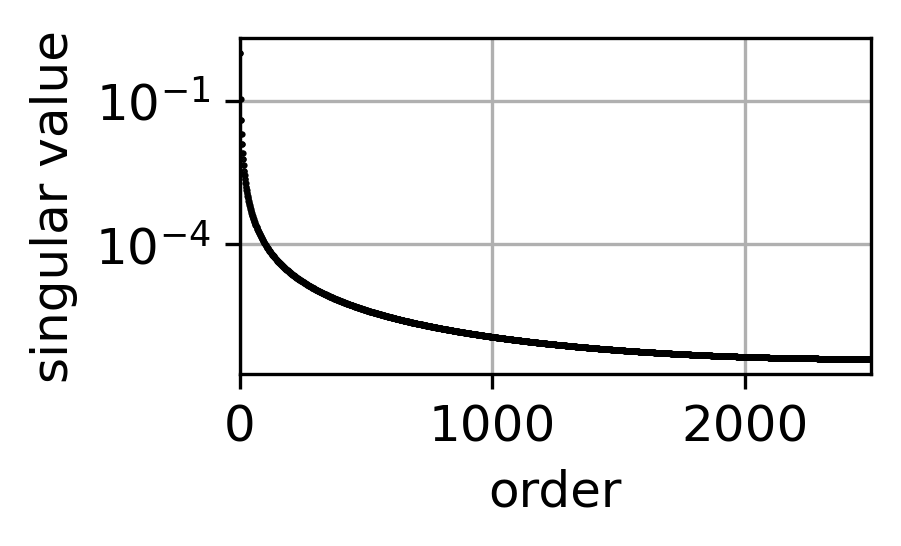

svd
smooth ramp, C^1


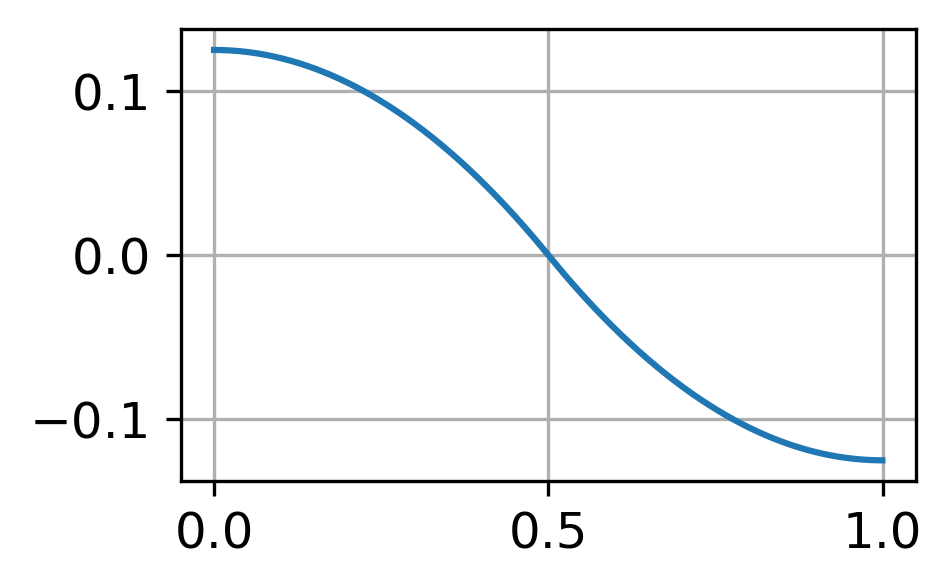

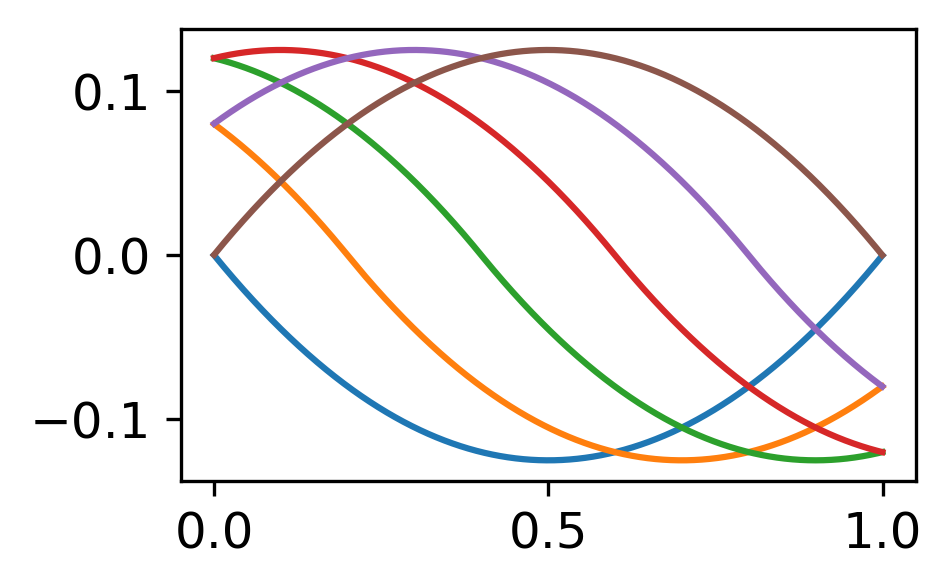

SVD'ed.


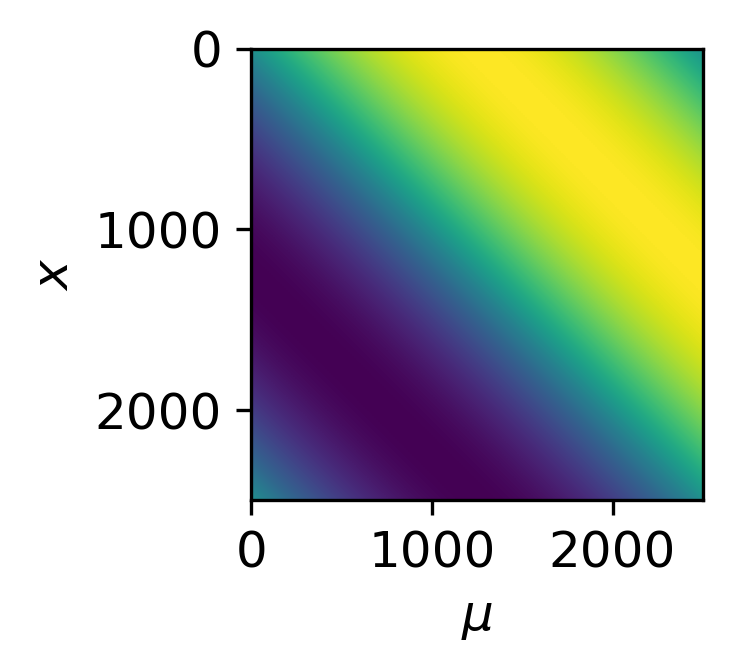

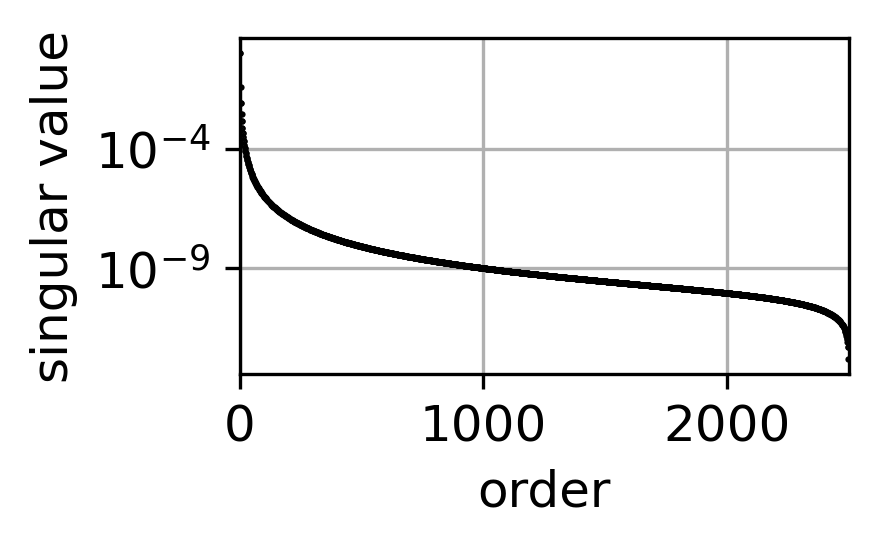

svd
smooth ramp, C^2


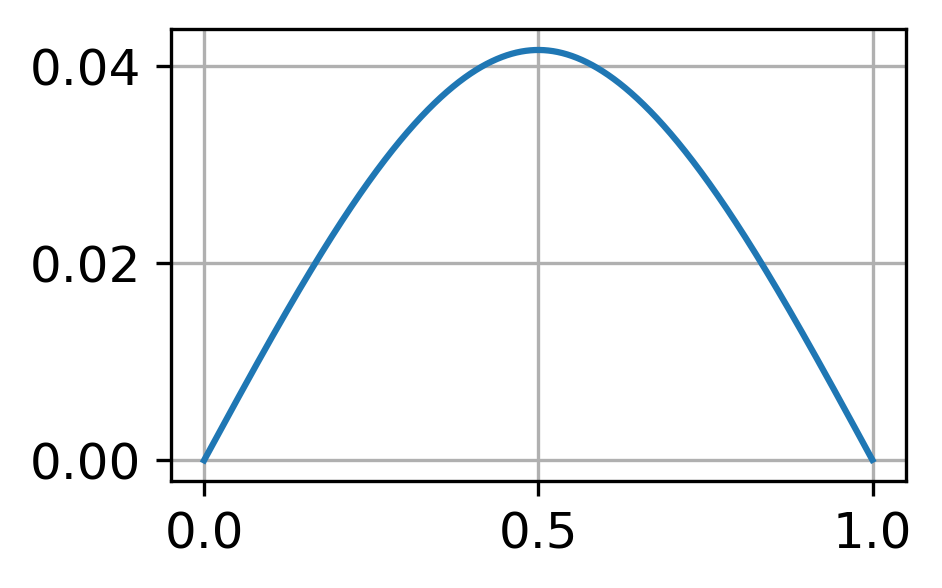

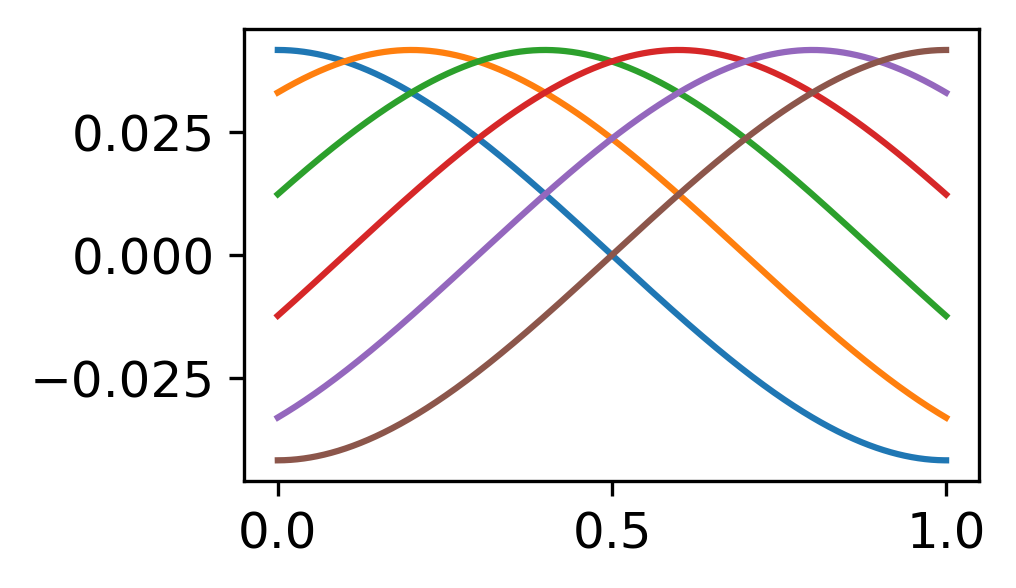

SVD'ed.


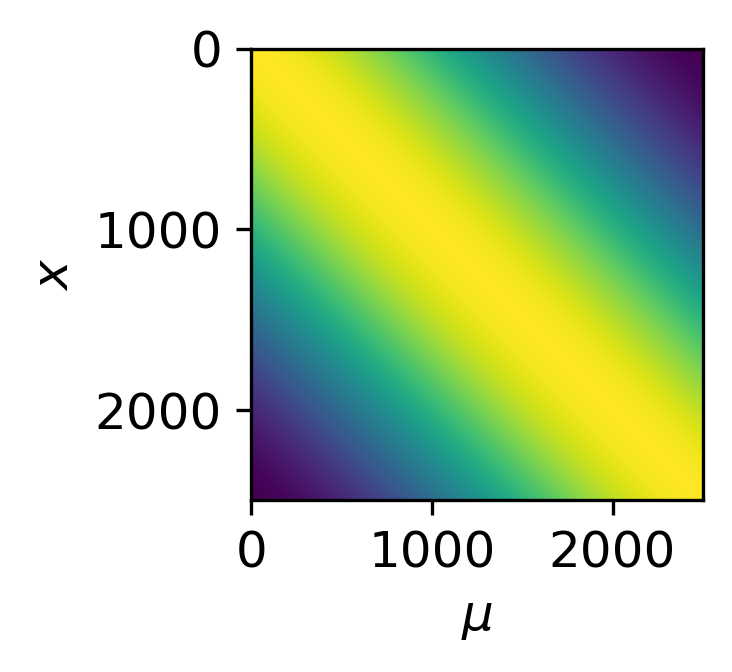

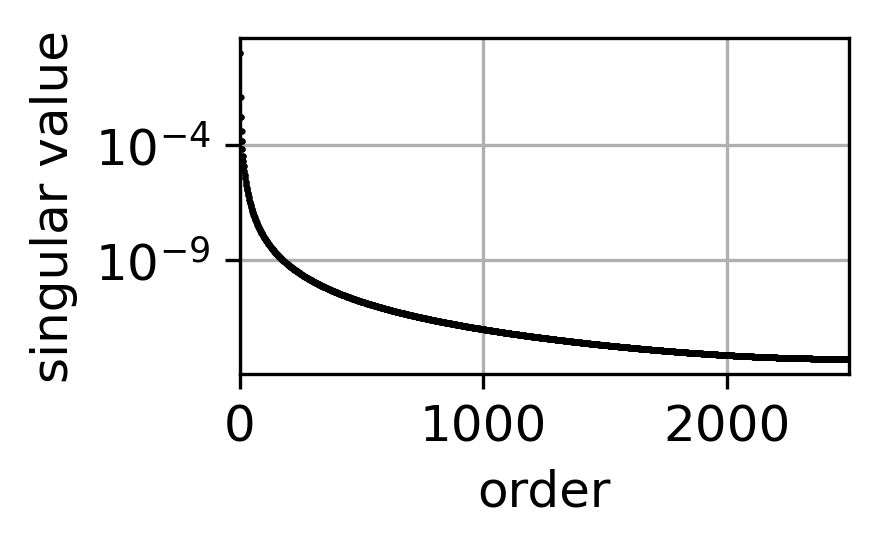

svd
smooth ramp, C^3


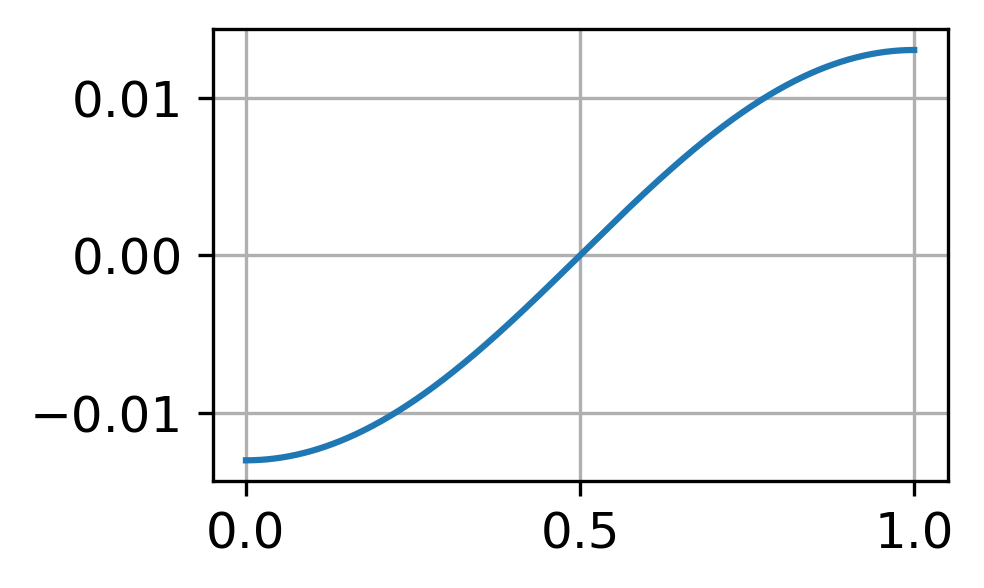

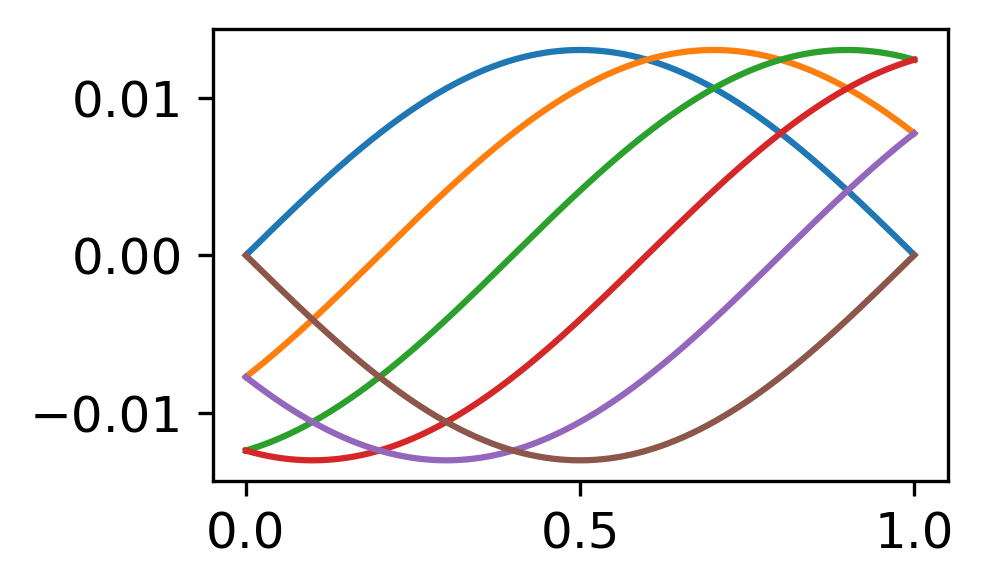

SVD'ed.


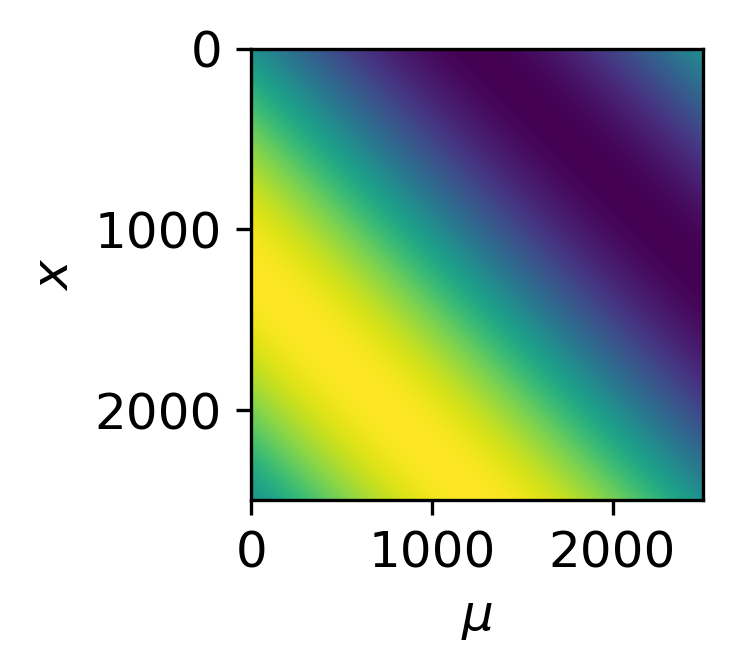

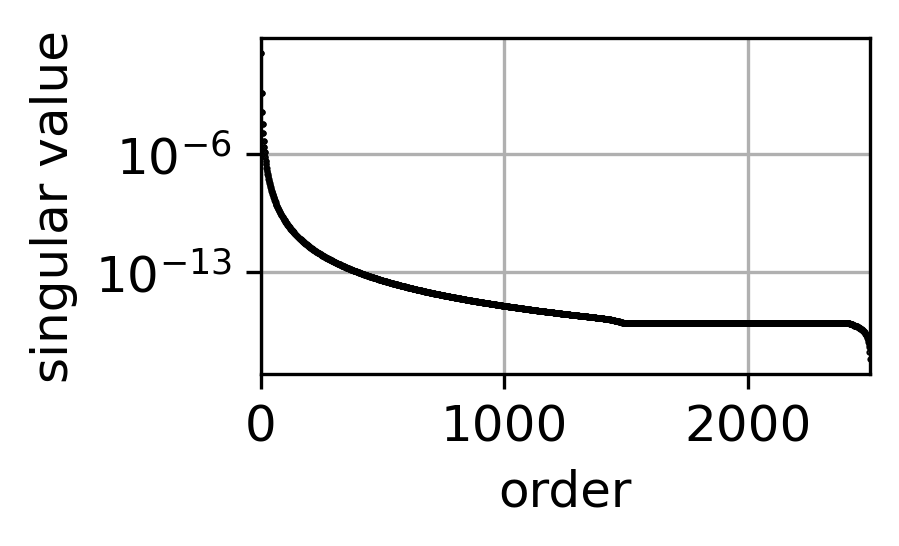

svd
smooth ramp, C^4


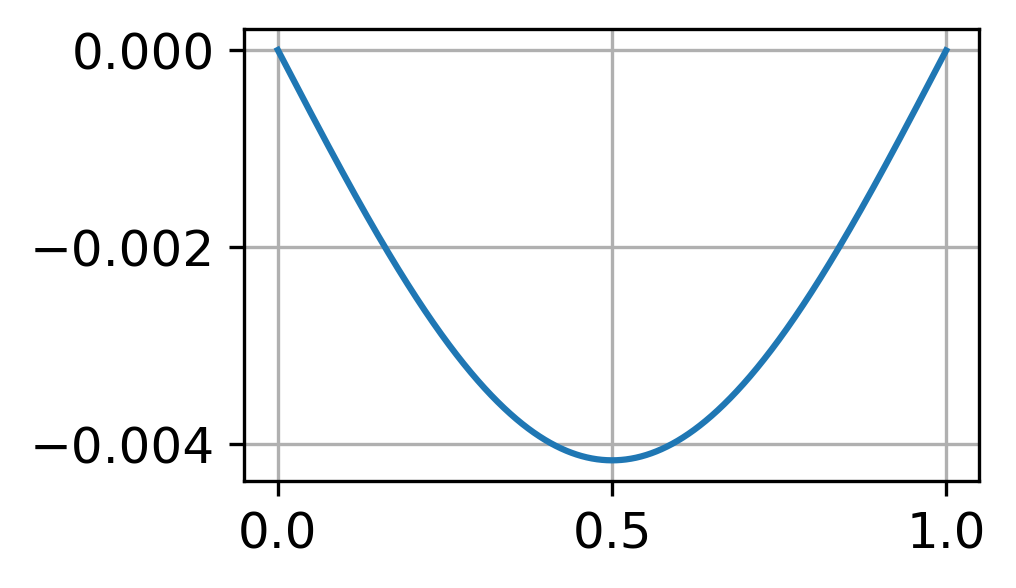

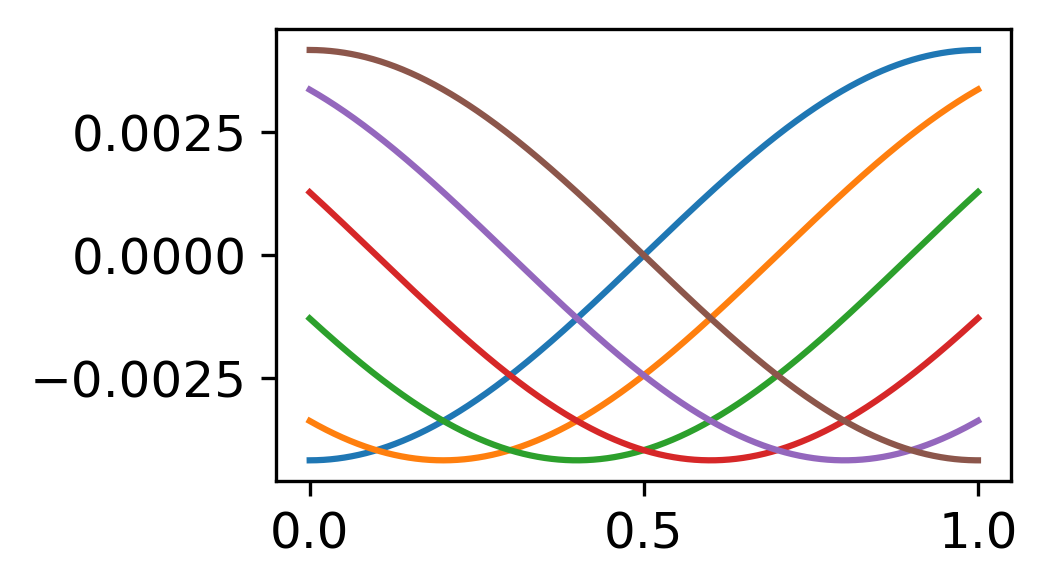

SVD'ed.


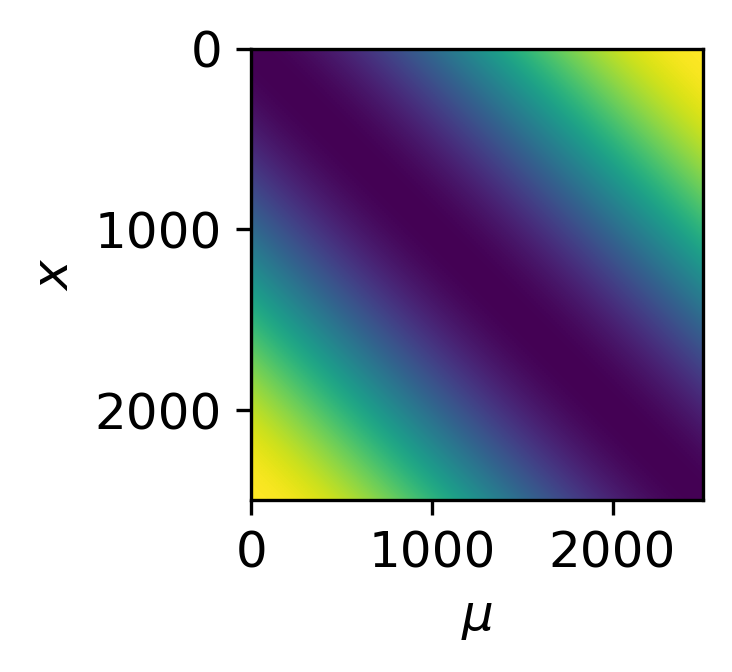

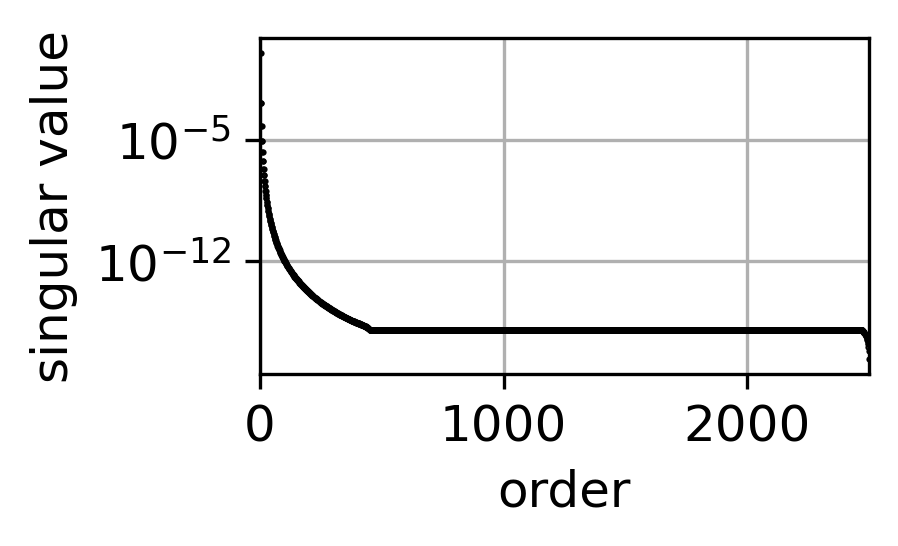

svd
smooth ramp, C^5


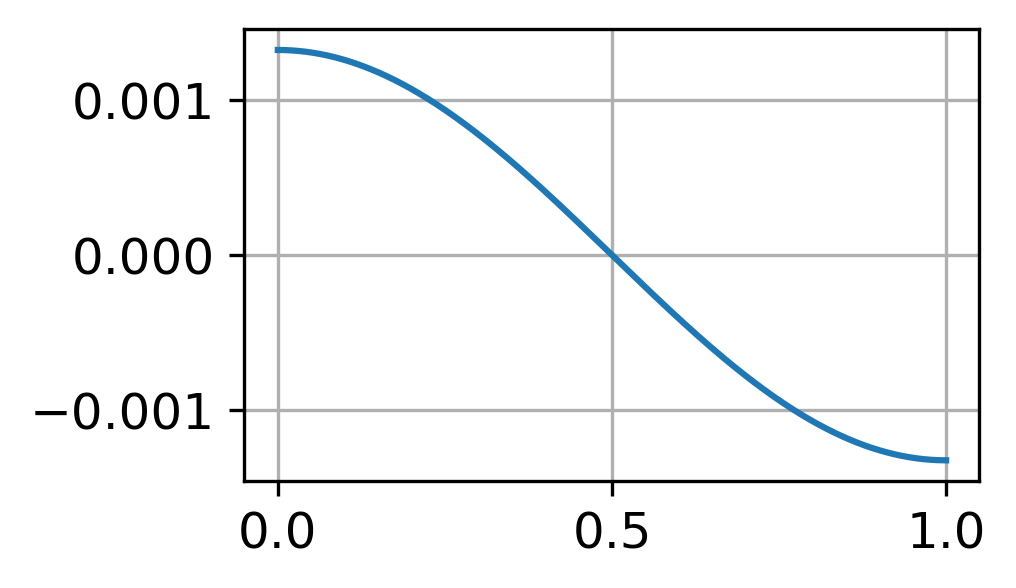

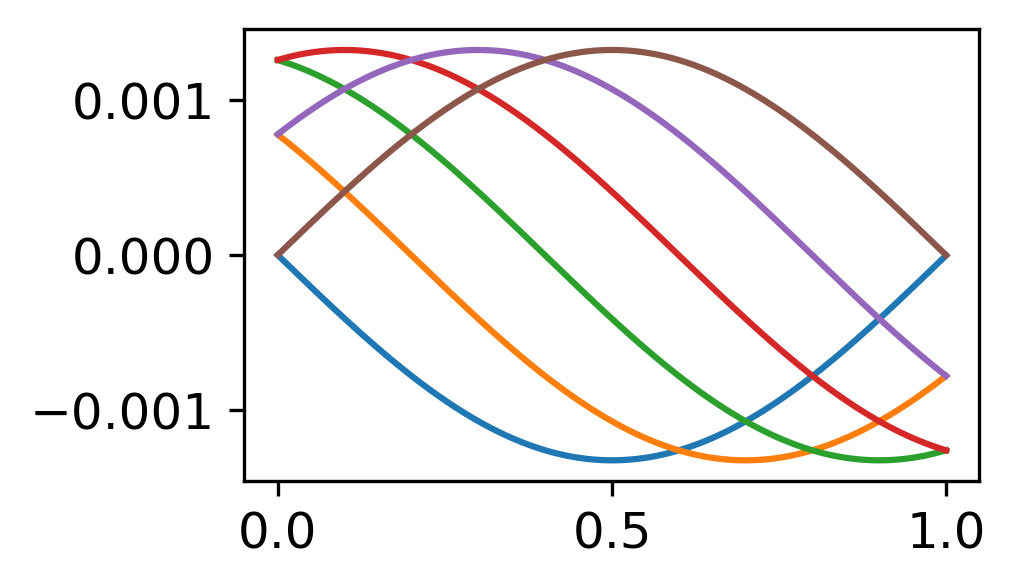

SVD'ed.


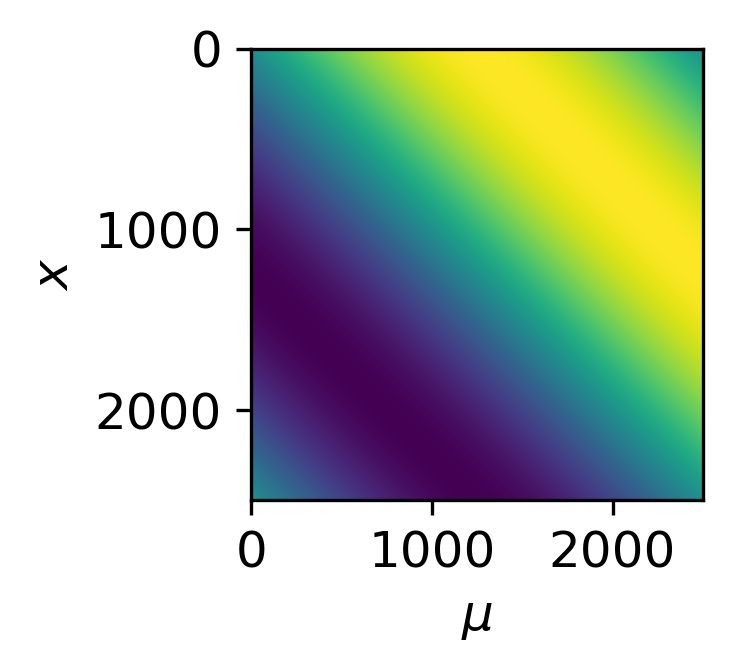

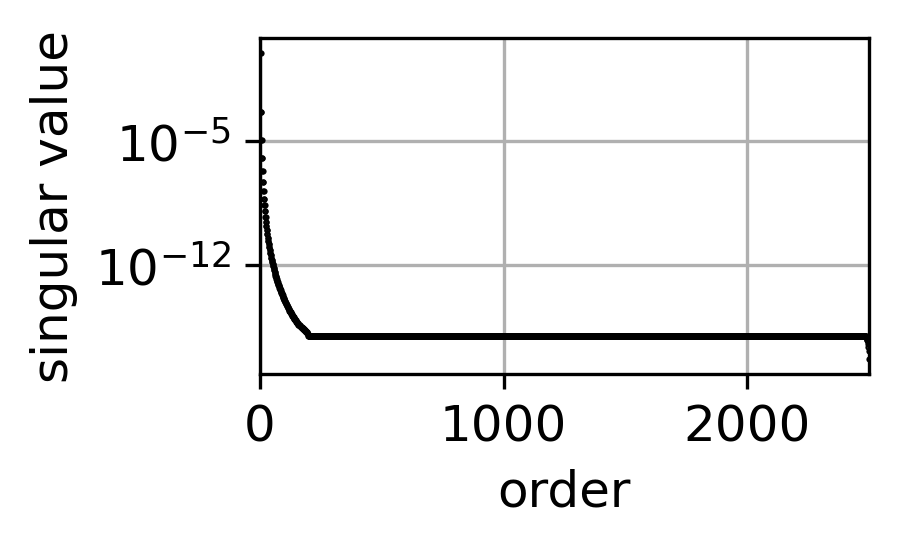

svd


In [8]:
#initc = [u_hs, u_lr, u_sr, u_C1, u_C2, u_C3, u_C4, u_C5, u_sg]
#basis = [svd_basis, trig_basis, greedy_basis, lna_basis, lpf_basis]
# 9 ic
# 5 bv
# 4 errors
# r entries

results = np.zeros((6, 9, 4, r))
epsilon = 0.025
u_hs = Heaviside()
u_C0 = Polynoms(epsilon, 0)
u_C1 = Polynoms(epsilon, 1)
u_C2 = Polynoms(epsilon, 2)
u_C3 = Polynoms(epsilon, 3)
u_C4 = Polynoms(epsilon, 4)
u_C5 = Polynoms(epsilon, 5)

tt = np.linspace(0, 1, 10000)
results_path = "C:/Users/florianma/Dropbox/Kol-N-width-Oslo-Ulm/n_widths_for_transport/results/hvo_"
initc = [u_hs, u_C0, u_C1, u_C2, u_C3, u_C4, u_C5]
for j, u_k in enumerate(initc):  # 9
    print(u_k.name)
    X = u_k(x(), mu())

    fig, ax = plt.subplots()
    for i in [1250]:
        plt.plot(x(), X[:, i])
    plt.grid()
    plt.show()
    fig, ax = plt.subplots()
    for i in [0, 499, 999, 1499, 1999, 2499]:
        plt.plot(x(), X[:, i])
    plt.show()

    svd_basis = SVD(X)
    print("SVD'ed.")

    plot_paramspace(X)
    plot_singular_values(svd_basis.S)

    basis_all = [svd_basis]
    for i, basis in enumerate(basis_all):  # 6
        print(basis.name)
        
        delta_n, d_n = basis.calc_error(X, r)
        results[i, j, 0, :] = delta_n
        results[i, j, 1, :] = d_n

(6, 9, 4, 500)
heaviside
linear ramp, $C^0$
44.90042441029246 3.4641016151377544
smooth ramp, $C^1$
22405.445855344064 4.47213595499958
smooth ramp, $C^2$
11214032.690659296 5.291502622129181
smooth ramp, $C^3$
5612665688.24619 6.0
smooth ramp, $C^4$
2809166093596.933 6.6332495807108
smooth ramp, $C^5$
1406003970830774.2 7.211102550927978


C:\Users\florianma\AppData\Local\Temp\ipykernel_30592\2118677887.py:29: RuntimeWarning: divide by zero encountered in power
  r = 2*(2*k+3)**.5 / np.pi**(k+2) * N**(-(k+1.5)) # Theorem 6.2 upper bound


Text(0, 0.5, '$\\int || u_j - \\tilde{u}_j ||_{L_2} d\\mu$')

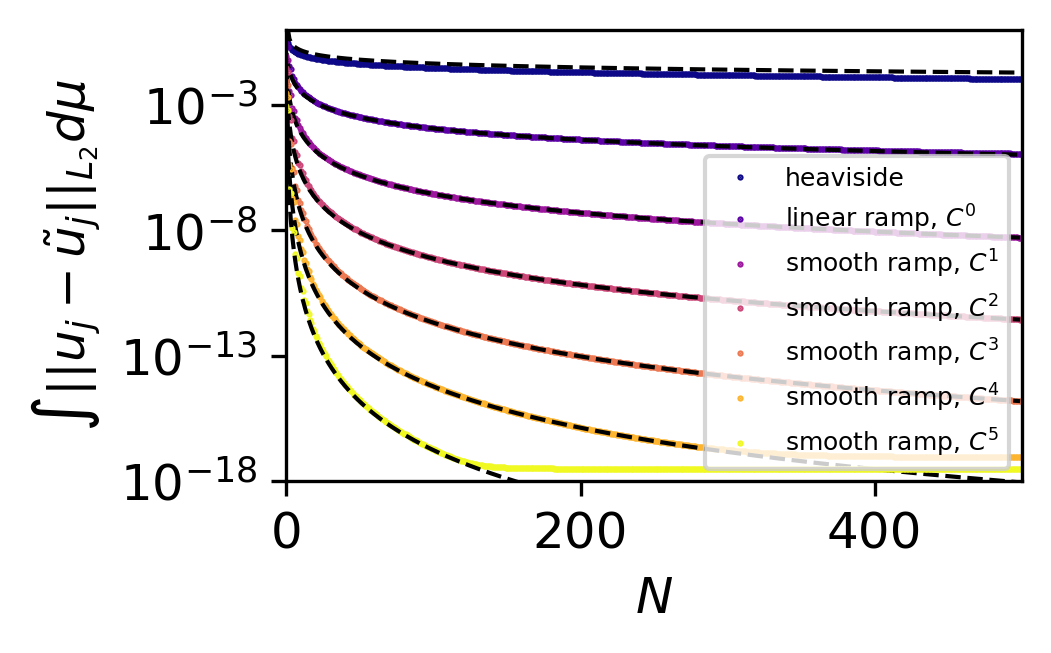

In [22]:
# np.save("C:/Users/florianma/Dropbox/Kol-N-width-Oslo-Ulm/data.npy", results)
i = 0
print(results.shape)

def L2(y, n):
    dy = np.diff(y.ravel(), n=n) * len(y)**n
    if n < -10:
        fig, ax = plt.subplots()
        plt.plot(dy)
        plt.show()
    return np.mean(dy**2)**.5


def model(N, c, y):
    if c == -1:
        # example 4.6: exact error
        N_inf = np.arange(10000)
        t = 8/ ((2*N_inf-1)**2*np.pi**2 )
        res = np.cumsum(t[::-1])[::-1]
        res = res[N]
        return res ** .5
    f_L2 = L2(y, c+1)
    if c<10:
        print(f_L2, 2*(2*k+3)**.5)
        
        Ninf = np.arange(1, 10000)
        #r = np.cumsum((4*(1/((2*np.floor((Ninf+1)/2)-1)*np.pi))**(2*k+4))[::-1])[::-1][N]**.5

        r = 2*(2*k+3)**.5 / np.pi**(k+2) * N**(-(k+1.5)) # Theorem 6.2 upper bound
        r = 2/(2*k+3)**.5 / np.pi**(k+2) * (N+1)**(-(k+1.5)) # Theorem 6.2 lower bound
        #r = f_L2/np.pi**(k+1)*N**(-(k+1)/1.0)  # theorem 5.4: upper bound
        #print(f_L2/np.pi**(k+1), -(k+1)/2.0)
        return r
    else:
        res = np.zeros(N.shape)
        for N_ in N:
            f_n_L2 = 2*L2(y, N_)  # N-th derivative!
            #print(N_, f_n_L2)
            res[N_] = f_n_L2/np.pi**N_ * N_**(-N_/1.0)
        return res

def grenze(N, n, c):
    return c * N** (-(2*n+3)/2)
    #return 1/np.pi**(n+1) * (N-1)** (-(n+1)/2)

N = np.arange(0, 500)
ks = [-1, 0, 1, 2, 3, 4, 5]
fig, ax = plt.subplots()
for j, ic in enumerate(initc):
    lbl = ic.name[:-3]+'$'+ic.name[-3:]+'$' if ic.name[-1].isdigit() else ic.name
    print(lbl)
    k = ks[j]
    sigma = results[i][j][0]
    color = cmap(j/6)
    ax.plot(N, sigma, ".", ms=1, color=color, label=lbl)
    y = ic.half_wave_odd(np.linspace(0,1, 500), np.array([0.5])).ravel()
    m = model(N, k, y) # * 1/20
    ax.plot(N, m, "k--", lw=1)

ax.set_ylim([1e-18, 1])
ax.set_xlim([0, 500]) 
ax.set_yscale('log')
ax.legend(prop={'size': 6})
ax.set_xlabel(r'$N$')
ax.set_ylabel(r'$\int || u_j - \tilde{u}_j ||_{L_2} d\mu$')
# decay HS:
#i = np.arange(1, 500)
#decay_exact_old = 2*(1/2 - 4/np.pi**2*np.cumsum(1/(2*i-1)**2))**.5
#decay_estimate = 2*(2/(i*np.pi**2))**.5
#ax1.plot(i, decay_exact_old, "g--", lw=.3)
#ax1.plot(i, decay_estimate, "r--", lw=.3)
#plt.show()